In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.rcParams['figure.figsize'] = [6, 6]

In [3]:
%cd ..

/home/belu/VS Workplace/licentiate-thesis-repo


In [343]:
import src.data.notebook_utils as utils

data_path = 'data/preproccess/no_constant_training.csv'

df = pd.read_csv(data_path)
df['_out_crystalscore'] = (df['_out_crystalscore'] == 4).astype(int)


In [344]:
df.columns

Index(['_feat_Refractivity', '_feat_MaximalProjectionRadius',
       '_feat_LengthPerpendicularToTheMaxArea', '_feat_molsurfaceareaASAp',
       '_feat_LengthPerpendicularToTheMinArea', '_feat_ProtPolarSurfaceArea',
       '_feat_minimalprojectionsize', '_feat_MolPol',
       '_feat_RotatableBondCount', '_feat_ChainAtomCount',
       '_feat_PolarSurfaceArea', '_feat_ASA_P', '_feat_VanderWaalsVolume',
       '_feat_maximalprojectionsize', '_feat_msareaVDWp', '_feat_Protpsa',
       '_feat_WienerIndex', '_rxn_reactiontimeS', '_feat_AtomCount_C',
       '_rxn_M_inorganic', '_feat_ASA', '_feat_BondCount',
       '_feat_WienerPolarity', '_feat_BalabanIndex', '_rxn_stirrateRPM',
       '_feat_Aliphatic AtomCount', '_feat_MinimalProjectionArea',
       '_rxn_mixingtime2S', '_rxn_mixingtime1S', '_feat_msareaASAp',
       '_feat_MaximalProjectionArea', '_rxn_organic-inchikey',
       '_out_crystalscore', '_feat_ASA-', '_feat_MinimalProjectionRadius',
       '_feat_VanderWaalsSurfaceArea', '_fea

In [5]:
df_all = utils.read_data()
df_all = df_all.drop(["_rxn_mixingtime2S", "_rxn_stirrateRPM", "_rxn_mixingtime1S", "_rxn_reactiontimeS", "_rxn_organic-inchikey"], axis=1)
df_all['_out_crystalscore'] = (df_all['_out_crystalscore'] == 4).astype(int)


In [6]:
len(df)

3630

In [7]:
df[['_out_crystalscore']].value_counts()


_out_crystalscore
0                    2947
1                     683
dtype: int64

In [8]:
df = df.drop(["_rxn_mixingtime2S", "_rxn_stirrateRPM", "_rxn_mixingtime1S", "_rxn_reactiontimeS", "_rxn_organic-inchikey"], axis=1)

In [9]:
df.columns

Index(['_feat_Refractivity', '_feat_MaximalProjectionRadius',
       '_feat_LengthPerpendicularToTheMaxArea', '_feat_molsurfaceareaASAp',
       '_feat_LengthPerpendicularToTheMinArea', '_feat_ProtPolarSurfaceArea',
       '_feat_minimalprojectionsize', '_feat_MolPol',
       '_feat_RotatableBondCount', '_feat_ChainAtomCount',
       '_feat_PolarSurfaceArea', '_feat_ASA_P', '_feat_VanderWaalsVolume',
       '_feat_maximalprojectionsize', '_feat_msareaVDWp', '_feat_Protpsa',
       '_feat_WienerIndex', '_feat_AtomCount_C', '_rxn_M_inorganic',
       '_feat_ASA', '_feat_BondCount', '_feat_WienerPolarity',
       '_feat_BalabanIndex', '_feat_Aliphatic AtomCount',
       '_feat_MinimalProjectionArea', '_feat_msareaASAp',
       '_feat_MaximalProjectionArea', '_out_crystalscore', '_feat_ASA-',
       '_feat_MinimalProjectionRadius', '_feat_VanderWaalsSurfaceArea',
       '_feat_ASA_H', '_feat_HyperWienerIndex', '_feat_ASA+', '_feat_AvgPol',
       '_feat_molsurfaceareaVDWp', '_rxn_M_acid', 

In [10]:
rings_feat = ['_feat_CyclomaticNumber',
 '_feat_CarboaromaticRingCount',
 '_feat_CarboRingCount',
 '_feat_LargestRingSize',
 '_feat_RingAtomCount',
 '_feat_SmallestRingSize',
 '_feat_AromaticRingCount',
 '_feat_AromaticAtomCount']
columns_arbitrary_decision = ["_feat_BalabanIndex", "_feat_VanderWaalsSurfaceArea", "_feat_VanderWaalsVolume", "_feat_ASA", "_feat_WienerIndex", "_feat_maximalprojectionsize"]
continous_feat = ['_feat_molsurfaceareaVDWp', '_feat_maximalprojectionsize', '_feat_MinimalProjectionArea', '_feat_minimalprojectionsize', '_feat_MaximalProjectionArea', '_feat_MolPol', '_feat_ASA_P', '_feat_msareaVDWp', '_feat_ASA', '_feat_ASA-', '_feat_MinimalProjectionRadius', '_feat_molsurfaceareaASAp', '_feat_LengthPerpendicularToTheMinArea', '_feat_WienerIndex', '_feat_ASA+', '_feat_MaximalProjectionRadius', '_feat_VanderWaalsSurfaceArea', '_feat_LengthPerpendicularToTheMaxArea', '_feat_VanderWaalsVolume', '_feat_BalabanIndex', '_feat_ASA_H', '_feat_HyperWienerIndex', '_feat_msareaASAp', '_feat_Refractivity', '_feat_AvgPol']
rxn_feat = ["_rxn_M_acid", "_rxn_M_organic", "_rxn_M_inorganic", "_out_crystalscore"] 


In [11]:
def cross_val_model_list(df, models, scoring, seed=1):

  X = df.drop(['_out_crystalscore'], axis=1)
  y = df['_out_crystalscore']

  results = np.zeros((len(models["classifiers"]),4))

  for index, m in enumerate(models["classifiers"]):
      clf = make_pipeline(StandardScaler(), m)
      result = pd.DataFrame(cross_validate(clf, X, y, return_train_score = True, scoring=scoring, cv = StratifiedKFold(n_splits=3, random_state=seed, shuffle=True), n_jobs=-1))
      scores = result[["test_precision", "test_matt", "train_precision", "train_matt"]].mean().values
      results[index,:] = scores

  model_df = pd.DataFrame({"test_precision": results[:,0], "test_matt": results[:,1], 
                          "train_precision": results[:,2], "train_matt": results[:,3]})
  model_df["model"] = models["names"]
  return model_df


def cross_val_smote_model_list(df, models, scoring, seed=1):

  X = df.drop(['_out_crystalscore'], axis=1)
  y = df['_out_crystalscore']

  results = np.zeros((len(models["classifiers"]),4))

  for index, m in enumerate(models["classifiers"]):
      clf = Pipeline([('smt', SMOTE(sampling_strategy = 0.5, random_state=42)), ('std', StandardScaler()), ('clf', m)])
      result = pd.DataFrame(cross_validate(clf, X, y, return_train_score = True, scoring=scoring, cv = StratifiedKFold(n_splits=3, random_state=seed, shuffle=True), n_jobs=-1))
      scores = result[["test_precision", "test_matt", "train_precision", "train_matt"]].mean().values
      results[index,:] = scores

  model_df = pd.DataFrame({"test_precision": results[:,0], "test_matt": results[:,1], 
                          "train_precision": results[:,2], "train_matt": results[:,3]})
  model_df["model"] = models["names"]
  return model_df


  
def show_cross_val_model_list(df, models, scoring, smote=False, seed=1):
  if smote: res = cross_val_smote_model_list(df, models, scoring, seed)
  else: res = cross_val_model_list(df, models, scoring, seed)
  return res.sort_values(by=['test_precision'], ascending=False).style.background_gradient(subset=['test_precision'])

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def apply_oversampling(df):
  X = df.drop(['_out_crystalscore'], axis=1)
  y = df['_out_crystalscore']
  sm = SMOTE(sampling_strategy = 0.6, random_state=42)
  X_res, y_res = sm.fit_resample(X_train, y_train)
  return pd.concat([X_res, y_res], axis=1)


def oversample_confusion_matrix_for_model_and_data(df, model, title, n_split=1):
  X = df.drop(['_out_crystalscore'], axis=1)
  y = df['_out_crystalscore']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  sm = SMOTE(sampling_strategy = 0.5, random_state=11)

  X_res, y_res = sm.fit_resample(X_train, y_train)

  clf = make_pipeline(StandardScaler(), RandomForestClassifier())

  clf.fit(X_res, y_res)

  y_pred = clf.predict(X_test)

  print_confusion_matrix(y_test, y_pred, title)  



def confusion_matrix_for_model_and_data(df, model, title):
  X = df.drop(['_out_crystalscore'], axis=1)
  y = df['_out_crystalscore']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  clf = make_pipeline(StandardScaler(), model())
 
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  print_confusion_matrix(y_test, y_pred, title)  

def print_confusion_matrix(y_test, y_pred, title=""):
  cf_matrix = confusion_matrix(y_test, y_pred)
  group_names = ['Verdadero Negativo \n`No Cristaliza`', 'Falso Negativo:\n Errado `No Cristaliza`', 'Falso Positivo:\n Errado Cristaliza', 'Verdadero Positivo: \n Cristaliza']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  matt = matthews_corrcoef(y_test, y_pred)
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Blues")
  ax.set_title(title)
  stats_text = "\n Matthews={:0.3f}\nAccuracy={:0.3f}\nPrecisión={:0.3f}\nRecall={:0.3f}\nF1={}".format(matt, accuracy, precision, recall, f1_score)
  plt.ylabel('Etiqueta Verdadera')
  plt.xlabel('Etiqueta Predecida' + stats_text)


In [13]:
ensamble = VotingClassifier([('lr', KNeighborsClassifier()), ('rf', RandomForestClassifier(random_state=1)), ('gnb', BaggingClassifier(random_state=1))])
classifiers = [AdaBoostClassifier(), BaggingClassifier(random_state=1), GradientBoostingClassifier(random_state=1), DecisionTreeClassifier(random_state=1), ExtraTreesClassifier(random_state=1), KNeighborsClassifier(), RandomForestClassifier(random_state=1), LogisticRegression(), SVC(), 
           ensamble ]
models_names = ["AdaBoost", "Bagging", "GBC", "DT", "ExtraTrees", "KNN", "RF", "LR", "SVC", "ensamble"]
models = {"classifiers": classifiers, "names": models_names}
scoring = {"matt": make_scorer(matthews_corrcoef), "precision": make_scorer(precision_score) }

In [ ]:
show_cross_val_model_list(df, models, scoring, 10)


,test_precision,test_matt,train_precision,train_matt,model
4,0.754286,0.717032,0.998522,0.990518,ExtraTrees
1,0.721268,0.674989,0.980292,0.974774,Bagging
6,0.721117,0.683696,0.994144,0.990530,RF
9,0.720783,0.689164,0.987525,0.981949,ensamble
3,0.672590,0.628213,0.998522,0.990518,DT
5,0.657488,0.675545,0.750846,0.791406,KNN
2,0.635163,0.632333,0.704733,0.726825,GBC
8,0.554772,0.572256,0.577777,0.607466,SVC
0,0.529249,0.511119,0.561384,0.564727,AdaBoost
7,0.494603,0.473723,0.502312,0.481527,LR


In [ ]:
show_cross_val_model_list(df, models, scoring, smote=True, seed=10)

,test_precision,test_matt,train_precision,train_matt,model
4,0.751845,0.705411,0.997784,0.991871,ExtraTrees
6,0.746581,0.700231,0.994864,0.991878,RF
9,0.744486,0.708797,0.990400,0.982824,ensamble
1,0.733011,0.675555,0.988821,0.975093,Bagging
3,0.670870,0.615169,0.997784,0.991871,DT
5,0.666048,0.665003,0.774226,0.805192,KNN
2,0.653802,0.628702,0.742456,0.740590,GBC
8,0.568108,0.565330,0.589336,0.600341,SVC
0,0.548253,0.501808,0.584080,0.552796,AdaBoost
7,0.500031,0.439194,0.507041,0.449715,LR


In [ ]:
res_all_no_drop = exp_cross_val_with_model_and_scoring(df_all, models, scoring,runs=10)
res_all_no_drop.groupby(by="model").mean()



,test_precision,test_matt
model,,
Bagging,0.778933,0.659202
ExtraTree,0.792655,0.702807
KNN,0.770357,0.695727
RF,0.799298,0.694201
ensamble,0.805207,0.702796


In [ ]:
res_all = exp_cross_val_with_model_and_scoring(df_all.drop(rings_feat,axis=1), models, scoring,runs=10)
res_all.groupby(by="model").mean()



,test_precision,test_matt
model,,
Bagging,0.775330,0.658744
ExtraTree,0.796534,0.706235
KNN,0.770688,0.695671
RF,0.802874,0.697423
ensamble,0.806701,0.702611


In [ ]:
selected = [KNeighborsClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), BaggingClassifier(),
            ensamble, GradientBoostingClassifier()]

models_name = ["KNN", "RF", "ExtraTree", "Bagging", "ensamble", "GBC"]

models = {"classifiers": selected, "names":models_name}

def exp_cross_val_with_model_and_scoring(df, models, scoring, runs=2):
    experimentation = [cross_val_model_list(df, models, scoring, seed) for seed in range(runs)]
    return pd.concat(experimentation, axis=0)
    

In [ ]:
res_only = exp_cross_val_with_model_and_scoring(df_all[continous_feat], models, scoring,runs=10)
res_only.groupby(by="model").mean()



,test_precision,test_matt
model,,
Bagging,0.770998,0.648872
ExtraTree,0.792182,0.697769
GBC,0.774096,0.593651
KNN,0.773907,0.696100
RF,0.797179,0.689242
ensamble,0.802829,0.693537


In [ ]:
res_only_rxn = exp_cross_val_with_model_and_scoring(df_all[rxn_feat], models, scoring,runs=10)
res_only_rxn.groupby(by="model").mean()

,test_precision,test_matt
model,,
Bagging,0.612313,0.353620
ExtraTree,0.679165,0.379686
GBC,0.796579,0.293264
KNN,0.558758,0.318990
RF,0.689414,0.382674
ensamble,0.696943,0.382218


In [ ]:
res_only_rxn = exp_cross_val_with_model_and_scoring(df_all[columns_arbitrary_decision + rxn_feat], models, scoring,runs=10)
res_only_rxn.groupby(by="model").mean()

,test_precision,test_matt
model,,
Bagging,0.786463,0.652178
ExtraTree,0.788899,0.695500
GBC,0.788621,0.585565
KNN,0.767493,0.682574
RF,0.797684,0.688437
ensamble,0.807946,0.693808


In [ ]:
one_amine_data_path = 'data/preproccess/only_one_amine.csv'

df_one_amine = pd.read_csv(one_amine_data_path)

df_one_amine[['_out_crystalscore']].value_counts()


_out_crystalscore
0                    483
1                    218
dtype: int64

In [ ]:
res_only_rxn = exp_cross_val_with_model_and_scoring(df_one_amine[rxn_feat], models, scoring,runs=10)
res_only_rxn.groupby(by="model").mean()

,test_precision,test_matt
model,,
AdaBoost,0.705439,0.532484
Bagging,0.774722,0.597560
DT,0.678833,0.530829
ExtraTrees,0.782879,0.598847
GBC,0.787274,0.616474
KNN,0.675896,0.501989
LR,0.022674,-0.080644
RF,0.811208,0.628752
SVC,0.736717,0.417279


701

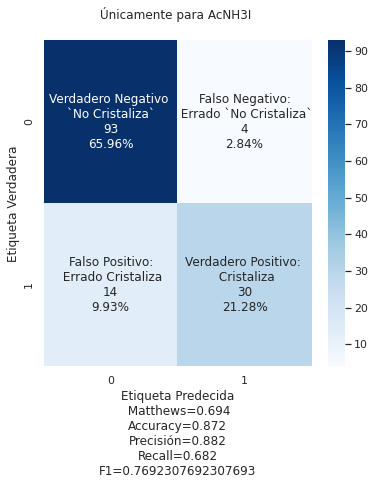

In [ ]:
confusion_matrix_for_model_and_data(df_one_amine[rxn_feat], RandomForestClassifier, "Únicamente para AcNH3I \n")
len(df_one_amine)

701

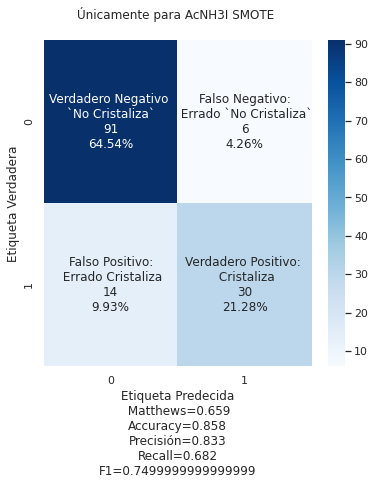

In [ ]:
oversample_confusion_matrix_for_model_and_data(df_one_amine[rxn_feat], RandomForestClassifier, "Únicamente para AcNH3I SMOTE \n")
len(df_one_amine)

6

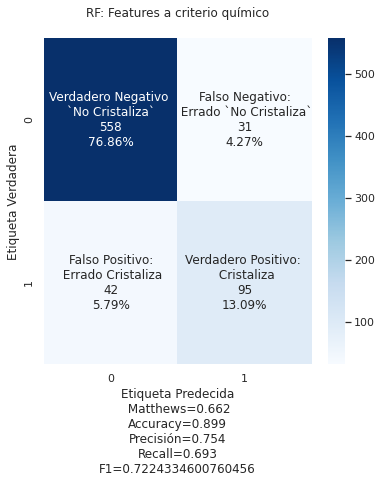

In [ ]:
confusion_matrix_for_model_and_data(df_all[columns_arbitrary_decision + rxn_feat], 
                                    RandomForestClassifier,
                                     "RF: Features a criterio químico\n")
len(columns_arbitrary_decision)

701

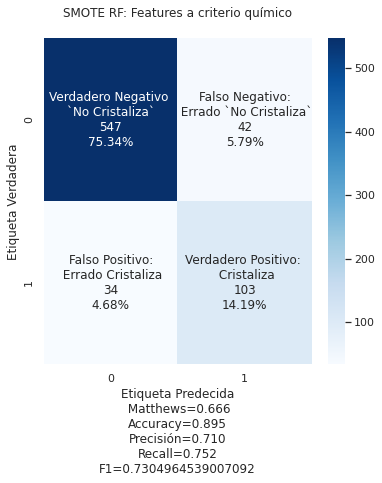

In [ ]:
oversample_confusion_matrix_for_model_and_data(df_all[columns_arbitrary_decision + rxn_feat], 
                                    RandomForestClassifier,
                                     "SMOTE RF: Features a criterio químico\n")
len(df_one_amine)

29

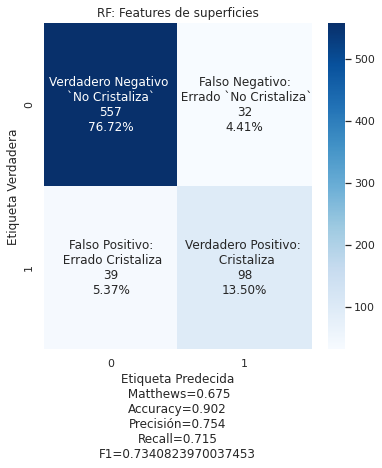

In [ ]:
confusion_matrix_for_model_and_data(df_all[continous_feat], 
                                    RandomForestClassifier,
                                    "RF: Features de superficies")
len(continous_feat)

29

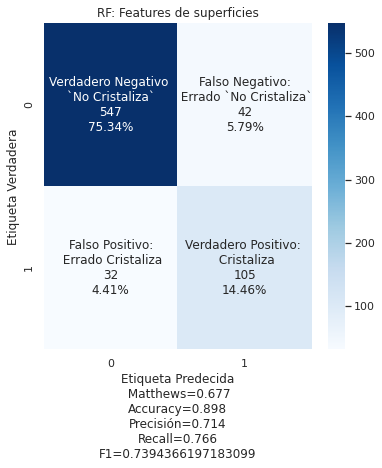

In [ ]:
oversample_confusion_matrix_for_model_and_data(df_all[continous_feat], 
                                    RandomForestClassifier,
                                    "RF: Features de superficies")
len(continous_feat)

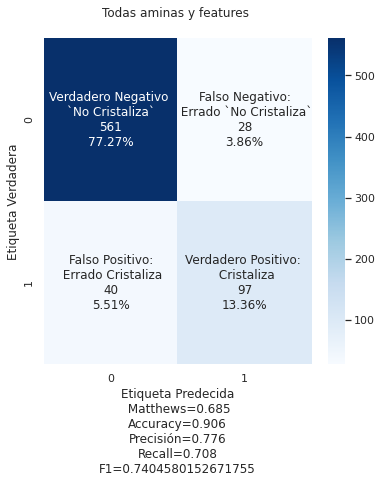

In [ ]:
confusion_matrix_for_model_and_data(df_all[rings_feat + continous_feat], 
                                    RandomForestClassifier,
                                    "Todas aminas y features \n")


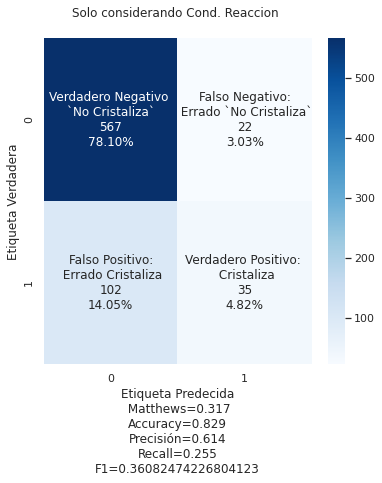

In [ ]:
confusion_matrix_for_model_and_data(df_all[rxn_feat], 
                                    RandomForestClassifier,
                                    "Solo considerando Cond. Reaccion \n")


In [130]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

scoring_sample = {"matt": make_scorer(matthews_corrcoef), "precision": make_scorer(precision_score),
                 "recall": make_scorer(recall_score), "f1": make_scorer(f1_score)
                 }


In [123]:
def cross_val_adasyn_model_list(df, models, scoring, seed=1):

  X = df.drop(['_out_crystalscore'], axis=1)
  y = df['_out_crystalscore']

  results = np.zeros((len(models["classifiers"]),4))

  for index, m in enumerate(models["classifiers"]):
      clf = Pipeline([('smt', ADASYN(sampling_strategy = 0.5, random_state=42)), ('std', StandardScaler()), ('clf', m)])
      result = pd.DataFrame(cross_validate(clf, X, y, return_train_score = True, scoring=scoring, cv = StratifiedKFold(n_splits=3, random_state=seed, shuffle=True), n_jobs=-1))
      scores = result[["test_precision", "test_matt", "train_precision", "train_matt"]].mean().values
      results[index,:] = scores

  model_df = pd.DataFrame({"test_precision": results[:,0], "test_matt": results[:,1], 
                          "train_precision": results[:,2], "train_matt": results[:,3]})
  model_df["model"] = models["names"]
  return model_df


In [336]:
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN 

def run_smote_with(df, model):
    X = df.drop(['_out_crystalscore'], axis=1)
    y = df['_out_crystalscore']

    # define model
    ada = ADASYN(random_state=42, sampling_strategy=0.4, n_jobs = -1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    adasyn = [('std', StandardScaler()), ('ada', ada), ('model', model)] 
    border_steps = [('std', StandardScaler()), ('over', BorderlineSMOTE(sampling_strategy=0.4)), ('model', model)] 
    steps_both = [('std', StandardScaler()), ('over', SMOTE(sampling_strategy=0.4)), ('under', under), ('model', model)] 
    steps = [('std', StandardScaler()), ('over', SMOTE(sampling_strategy=0.5)), ('model', model)]
    steps_no_smote = [('std', StandardScaler()), ('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline_no_smote = Pipeline(steps=steps_no_smote)
    pipeline_both = Pipeline(steps=steps_both)
    pipeline_border = Pipeline(steps=border_steps)
    pipeline_ada = Pipeline(steps=adasyn)

    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=40, random_state=2)
    scores = cross_validate(pipeline, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_no_smote = cross_validate(pipeline_no_smote, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_both = cross_validate(pipeline_both, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_border = cross_validate(pipeline_border, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    scores_ada = cross_validate(pipeline_ada, X, y, scoring=scoring_sample, cv = cv, n_jobs=-1)
    dtm = pd.DataFrame(scores_both).join(pd.DataFrame(scores), lsuffix='_smote_under', rsuffix='_smote')
    results = dtm.join(pd.DataFrame(scores_no_smote), lsuffix='', rsuffix='_original_sampling')
    results_ada = results.join(pd.DataFrame(scores_ada), lsuffix='', rsuffix='_adasyn')
    final_results = results_ada.join(pd.DataFrame(scores_border), lsuffix='', rsuffix='_border_sampling')
    return (final_results.loc[:, final_results.columns.str.startswith('test')]).sort_index(axis=1)

def get_summary_exp_sampling_for_model_and_data(df, model):
    full_results = run_smote_with(df, model)
    full_results.columns = pd.MultiIndex.from_product(
                iterables=[["F1", "MCC", "Precisión", "Recall"], ["Sin Balanceo", "ADASYN", "SMOTE-Borde", "SMOTE", "SMOTE-Sub"]], 
                names=['Métrica', 'Método Balanceo'])
    return full_results

metrics_col = ["F1", "MCC", "Precisión", "Recall"]
hue_col = "Método Balanceo"

def boxplots_compared_columns_for_model(df, title, columns, hue_col, ylim=(0.6,0.9)):
    df = df.stack(level=1).reset_index(level=0, drop=True).reset_index()
    fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    fig.suptitle(title)

    plt.setp(axes, xlim=ylim)
    for num, column in enumerate(columns):
        sns.boxplot(ax=axes[num], x=column, y=hue_col, data=df, showfliers = False, 
            #medianprops=dict(color="yellow", alpha=1),
            linewidth=0.95)
        sns.swarmplot(ax=axes[num], x=column, y=hue_col, data=df, color="black", size=1.3)
        axes[num].set(ylabel=None)

def boxplot_all_columns_summary(df):
    sns.boxplot(data=df, orient="h")
    plt.show() 



In [320]:
limits = (0.45,0.95)
sns.set_theme()
sns.set_palette("pastel")


In [227]:
knn_data = get_summary_exp_sampling_for_model_and_data(df_all[columns_arbitrary_decision + rxn_feat] , KNeighborsClassifier())

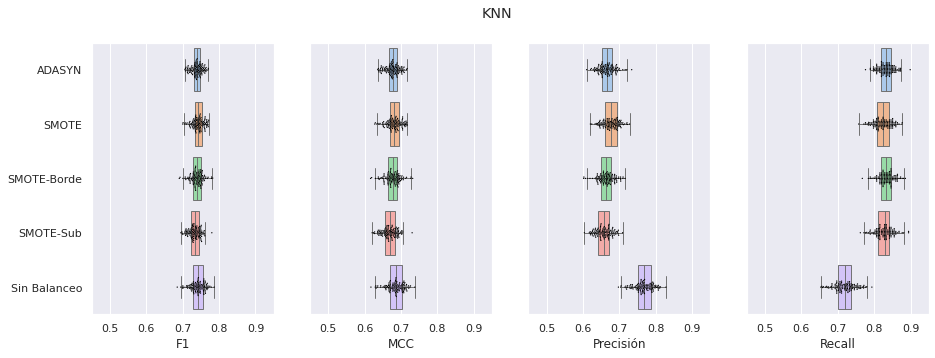

In [337]:
boxplots_compared_columns_for_model(knn_data, "KNN", metrics_col, hue_col, limits)


In [256]:
# se equivoca mucho más: cristaliza más seguido optimista
model = DecisionTreeClassifier(random_state = 1, max_depth=10, min_samples_leaf=9)
results_dt = get_summary_exp_sampling_for_model_and_data(df_all[columns_arbitrary_decision + rxn_feat] , model) 

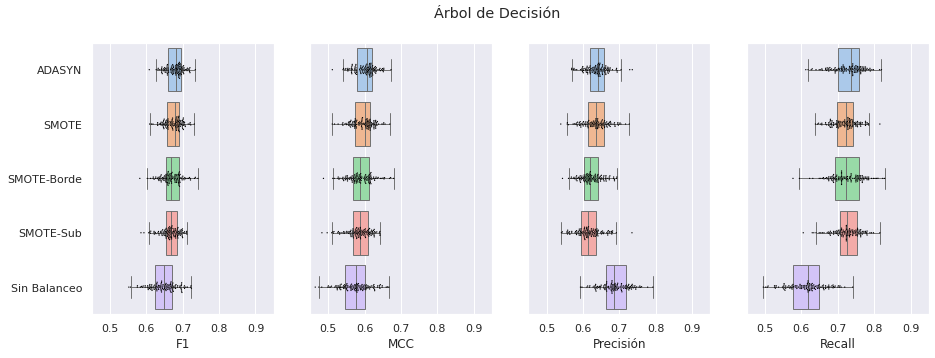

In [338]:
boxplots_compared_columns_for_model(results_dt, "Árbol de Decisión", metrics_col, hue_col, limits)

In [255]:
# se equivoca mucho más: cristaliza más seguido optimista
model = DecisionTreeClassifier(random_state = 1, max_depth=10, min_samples_leaf=9, class_weight="balanced")
results_dt_class_balanced = get_summary_exp_sampling_for_model_and_data(df_all[columns_arbitrary_decision + rxn_feat], model) 

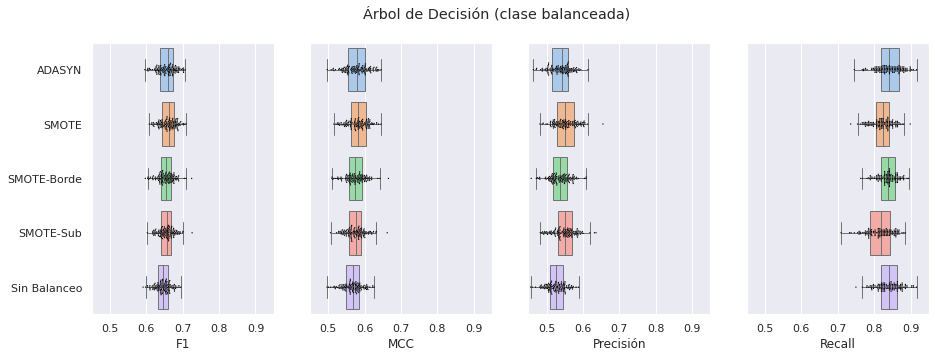

In [339]:
boxplots_compared_columns_for_model(results_dt_class_balanced, "Árbol de Decisión (clase balanceada)", metrics_col, hue_col, limits)


In [272]:
model = RandomForestClassifier(random_state = 1, max_depth=10, min_samples_leaf=9)
results_rf = get_summary_exp_sampling_for_model_and_data(df_all[rxn_feat+columns_arbitrary_decision], model)

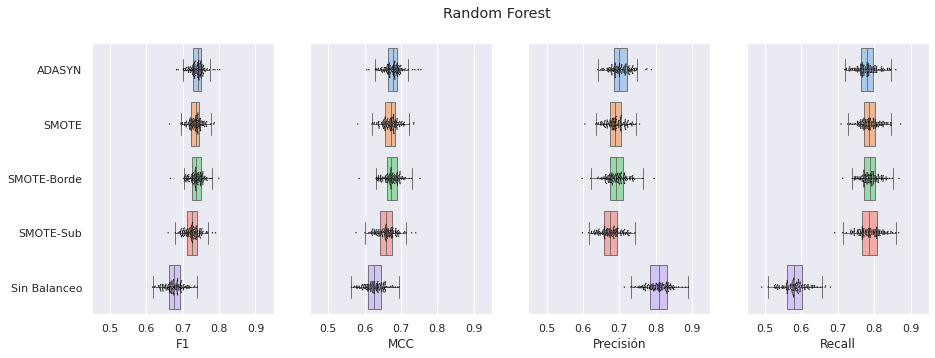

In [340]:
boxplots_compared_columns_for_model(results_rf, "Random Forest", metrics_col, hue_col, limits)

In [271]:
model = RandomForestClassifier(random_state = 1, max_depth=10, min_samples_leaf=9, class_weight="balanced")
results_rf_class_balanced = get_summary_exp_sampling_for_model_and_data(df_all[rxn_feat+columns_arbitrary_decision], model)

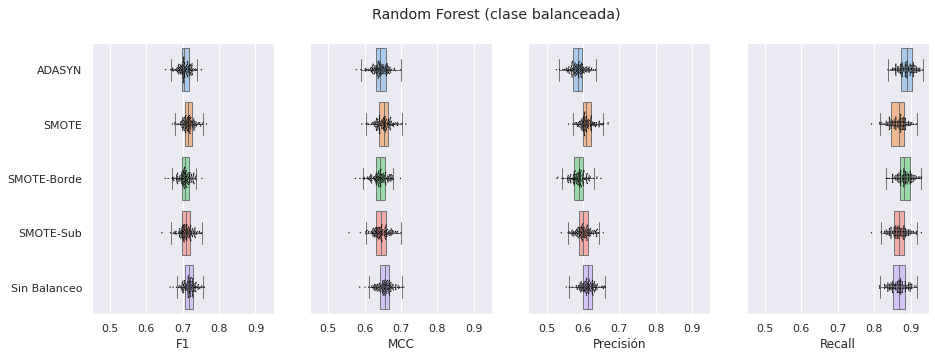

In [341]:
boxplots_compared_columns_for_model(results_rf_class_balanced, "Random Forest (clase balanceada)", metrics_col, hue_col, limits)


In [269]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(random_state = 1, max_depth=10, min_samples_leaf=9)
results_balanced_rf = get_summary_exp_sampling_for_model_and_data(df_all[rxn_feat+columns_arbitrary_decision], model)


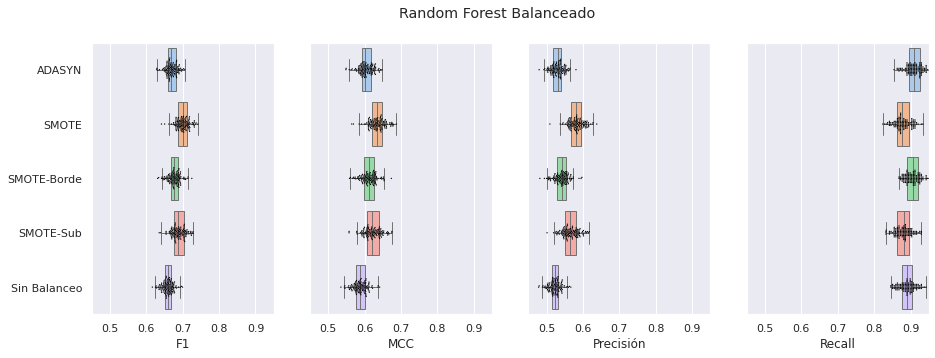

In [342]:
boxplots_compared_columns_for_model(results_balanced_rf, "Random Forest Balanceado", metrics_col, hue_col, limits)


In [51]:
# se ve una mejora general sin gran costo de equivocacion

for depth in [3, 5, 8]:
    for min_samples in [3, 6, 8]:
        model = DecisionTreeClassifier(random_state = 1, max_depth = depth, min_samples_leaf = min_samples)
        results_tree = get_summary_exp_sampling_for_model_and_data(df_all[rxn_feat+columns_arbitrary_decision], model)
        print("Profundidad: {} Min_muestras: {}".format(depth, min_samples))
        print(results_tree, depth, min_samples)

Profundidad: 3 Min_muestras: 3
                                    mean    median       std
test_matt                       0.215160  0.239077  0.086103
test_matt_adasyn                0.300075  0.277404  0.063611
test_matt_border_sampling       0.355632  0.375472  0.064651
test_matt_smote                 0.304001  0.291002  0.062949
test_matt_smote_under           0.311646  0.298165  0.067404
test_precision                  0.527234  0.535411  0.190349
test_precision_adasyn           0.458747  0.449733  0.040072
test_precision_border_sampling  0.439981  0.435972  0.031095
test_precision_smote            0.457132  0.435726  0.074635
test_precision_smote_under      0.454850  0.437969  0.068305
test_recall                     0.171153  0.217579  0.089673
test_recall_adasyn              0.399231  0.315789  0.168101
test_recall_border_sampling     0.554138  0.649123  0.163254
test_recall_smote               0.439164  0.406475  0.214428
test_recall_smote_under         0.454036  0.425439  0.

In [42]:
# se ve una mejora general sin gran costo de equivocacion

for depth in [3, 5, 80, 100, 200]:
    for min_samples in [3, 6, 8]:
        model = DecisionTreeClassifier(random_state = 1, max_depth = depth, min_samples_leaf = min_samples)
        results_tree = get_summary_exp_sampling_for_model_and_data(df_all[rxn_feat+columns_arbitrary_decision], model)
        print("Profundidad: {} Min_muestras: {}".format(depth, min_samples))
        print(results_tree, depth, min_samples)

Profundidad: 20 Min_muestras: 3
                                    mean    median       std
test_matt                       0.606442  0.609941  0.029514
test_matt_adasyn                0.616563  0.620969  0.026988
test_matt_border_sampling       0.609694  0.612092  0.033449
test_matt_smote                 0.621174  0.621980  0.034333
test_matt_smote_under           0.595972  0.600483  0.030379
test_precision                  0.699536  0.697817  0.033585
test_precision_adasyn           0.679057  0.678724  0.030452
test_precision_border_sampling  0.668908  0.669457  0.033604
test_precision_smote            0.678823  0.681617  0.032425
test_precision_smote_under      0.642779  0.645596  0.027296
test_recall                     0.658333  0.668135  0.036175
test_recall_adasyn              0.701529  0.701754  0.031962
test_recall_border_sampling     0.701896  0.705493  0.036122
test_recall_smote               0.710094  0.714912  0.035451
test_recall_smote_under         0.710896  0.714912  0

In [368]:
df = df_all[rxn_feat+columns_arbitrary_decision]
df.columns

Index(['_rxn_M_acid', '_rxn_M_organic', '_rxn_M_inorganic',
       '_out_crystalscore', '_feat_BalabanIndex',
       '_feat_VanderWaalsSurfaceArea', '_feat_VanderWaalsVolume', '_feat_ASA',
       '_feat_WienerIndex', '_feat_maximalprojectionsize'],
      dtype='object')

In [ ]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline


def grid_search_best_model_for(df, model, param_grid)
model = KNeighborsClassifier()

X = df.drop(['_out_crystalscore'], axis=1)
y = df['_out_crystalscore']

k_range = [2,4,6,9,12]
weight_options = ['uniform', 'distance']
algorithms = ["ball_tree", "kd_tree"]
param_grid = {  "model__n_neighbors": k_range, 
                "model__weights": weight_options, 
                "model__algorithm": algorithms
            }
print(param_grid)
# define model
ada = ADASYN(random_state=42, sampling_strategy=0.4, n_jobs = -1)
adasyn = [('std', StandardScaler()), ('ada', ada), ('model', model)] 
pipeline_ada = Pipeline(steps=adasyn)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=40, random_state=2)

clf = GridSearchCV(pipeline_ada, param_grid=param_grid, cv=cv, scoring=scoring_sample, n_jobs=-1, refit="matt")

clf.fit(X,y)

In [372]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline


model = KNeighborsClassifier()

X = df.drop(['_out_crystalscore'], axis=1)
y = df['_out_crystalscore']

k_range = [2,4,6,9,12]
weight_options = ['uniform', 'distance']
algorithms = ["ball_tree", "kd_tree"]
param_grid = {  "model__n_neighbors": k_range, 
                "model__weights": weight_options, 
                "model__algorithm": algorithms
            }
print(param_grid)
# define model
ada = ADASYN(random_state=42, sampling_strategy=0.4, n_jobs = -1)
adasyn = [('std', StandardScaler()), ('ada', ada), ('model', model)] 
pipeline_ada = Pipeline(steps=adasyn)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=40, random_state=2)

clf = GridSearchCV(pipeline_ada, param_grid=param_grid, cv=cv, scoring=scoring_sample, n_jobs=-1, refit="matt")

clf.fit(X,y)

{'model__n_neighbors': [2, 4, 6, 9, 12], 'model__weights': ['uniform', 'distance'], 'model__algorithm': ['ball_tree', 'kd_tree']}


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=40, n_splits=3, random_state=2),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('ada',
                                        ADASYN(n_jobs=-1, random_state=42,
                                               sampling_strategy=0.4)),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree'],
                         'model__n_neighbors': [2, 4, 6, 9, 12],
                         'model__weights': ['uniform', 'distance']},
             refit='matt',
             scoring={'f1': make_scorer(f1_score),
                      'matt': make_scorer(matthews_corrcoef),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [377]:
clf.best_estimator_

Pipeline(steps=[('std', StandardScaler()),
                ('ada',
                 ADASYN(n_jobs=-1, random_state=42, sampling_strategy=0.4)),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=12,
                                      weights='distance'))])

In [376]:
pd.DataFrame.from_dict(clf.cv_results_).to_csv("gs_knn_adasyn.csv")

In [387]:
df_test = pd.read_csv("data/testing-perovskite-data.csv")[rxn_feat+columns_arbitrary_decision]
df_test['_out_crystalscore'] = (df_test['_out_crystalscore'] == 4).astype(int)


In [390]:
def testing_data_confusion_matrix(df_test, clf, title):
    X_test = df_test.drop(['_out_crystalscore'], axis=1)
    y_test = df_test['_out_crystalscore']

    y_pred = clf.predict(X_test)
    print_confusion_matrix(y_test, y_pred, title)  


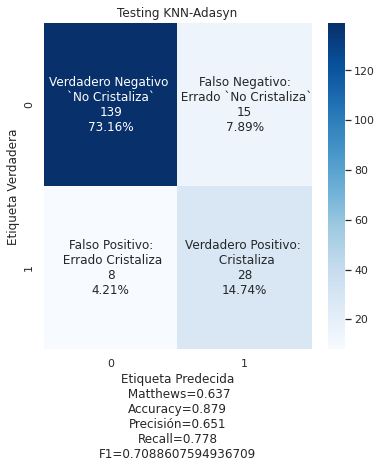

In [391]:
testing_data_confusion_matrix(df_test, clf, "Testing KNN-Adasyn")